In [1]:
import glob
import os
import pickle
import random
import sys

import dill
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import pyemma
import pymbar
import scipy
import seaborn as sns
from matplotlib import ticker

import prettypyplot as pplt

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [2]:
upside_path = "/project/dinner/scguo/upside2/"
upside_utils_dir = os.path.expanduser(upside_path + "/py")
sys.path.insert(0, upside_utils_dir)

In [3]:
plt.style.use("custom")  # custom style sheet
plt.style.use("vibrant")  # muted color theme from SciencePlots
pplt.load_cmaps()

plt.rcParams[
    "text.latex.preamble"
] = r"\usepackage{siunitx}\sisetup{detect-all}\usepackage{helvet}\usepackage{sansmath}\sansmath"
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = "cm"

In [4]:
%load_ext autoreload
%autoreload 1

In [5]:
# add patches
import matplotlib.patches as mpatches

In [6]:
def draw_ss(ax, y):
    width = 1.0
    height = 0.001
    artists = [
        mpatches.Arrow(8, y, 6, 0, width=width),
        mpatches.FancyBboxPatch((20, y - height / 2), 15, height, ec="none"),
        mpatches.Arrow(40, y, 6, 0, width=width),
        mpatches.FancyBboxPatch((49, y - height / 2), 7, height, ec="none"),
        mpatches.Arrow(63, y, 6, 0, width=width),
        mpatches.Arrow(72, y, 5, 0, width=width),
        mpatches.FancyBboxPatch((83, y - height), 11, height, ec="none"),
    ]
    for artist in artists:
        artist.set(color="C1")
        ax.add_artist(artist)

    ss_locs = [11, 27, 43, 52, 66, 74, 88]
    ss_labels = [
        r"$\beta1$",
        r"$\alpha1$",
        r"$\beta2$",
        r"$\alpha2$",
        r"$\beta3$",
        r"$\beta4$",
        r"$\alpha3$",
    ]
    for x, label in zip(ss_locs, ss_labels):
        ax.text(x, y + 0.5, label, ha="center")
    return ax

In [7]:
color_arr = []

for r in np.arange(0, 99):
    if r >= 8 and r <= 13:
        color = "navy"
    elif r >= 20 and r <= 34:
        color = "darkturquoise"
    elif r >= 40 and r <= 45:
        color = "mediumseagreen"
    elif r >= 49 and r <= 55:
        color = "honeydew"
    elif r >= 63 and r <= 68:
        color = "lawngreen"
    elif r >= 72 and r <= 76:
        color = "goldenrod"
    elif r >= 83 and r <= 95:
        color = "orangered"
    else:
        color = "slategray"
    color_arr.append(color)

In [8]:
from matplotlib.lines import Line2D

line_colors = [
    "navy",
    "darkturquoise",
    "mediumseagreen",
    "honeydew",
    "lawngreen",
    "goldenrod",
    "orangered",
    "slategray",
]
custom_lines = [Line2D([0], [0], color=c, lw=4) for c in line_colors]
ss_labels = [
    r"$\beta1$",
    r"$\alpha1$",
    r"$\beta2$",
    r"$\alpha2$",
    r"$\beta3$",
    r"$\beta4$",
    r"$\alpha3$",
    "Other",
]

# Load experimental data

In [9]:
exp_dir = "/project/dinner/scguo/kaiB/exp"
kobs_ph5_resids = np.loadtxt(f"{exp_dir}/kobs_pH5.5_ave.tab", usecols=0, dtype=str)
kobs_ph5 = np.loadtxt(f"{exp_dir}/kobs_pH5.5_ave.tab", usecols=(1, 2))
kobs_ph6_resids = np.loadtxt(f"{exp_dir}/kobs_pH6.5_ave.tab", usecols=0, dtype=str)
kobs_ph6 = np.loadtxt(f"{exp_dir}/kobs_pH6.5_ave.tab", usecols=(1, 2))

In [10]:
kchem_ph5 = np.loadtxt(f"{exp_dir}/sphere_kintr_pH5.5_12C.tab", skiprows=15, max_rows=92, usecols=(0, 2))
kchem_ph6 = np.loadtxt(f"{exp_dir}/sphere_kintr_pH6.5_12C.tab", skiprows=15, max_rows=92, usecols=(0, 2))

In [11]:
print(kobs_ph5_resids)
print(kobs_ph6_resids)

['A8' 'V9' 'L10' 'K11' 'L12' 'Y13' 'V14' 'G16' 'T18' 'V22' 'R23' 'A24'
 'L25' 'K26' 'T27' 'L28' 'N29' 'N30' 'E33' 'K34' 'F36' 'V39' 'Y40' 'A41'
 'L42' 'K43' 'V44' 'I45' 'V47' 'L48' 'K49' 'N50' 'L53' 'A54' 'D57' 'I59'
 'T64' 'L65' 'A66' 'K67' 'L69' 'R74' 'I76' 'E84' 'K85' 'V86' 'L87' 'A89'
 'L90' 'R91' 'L92' 'L93' 'A94']
['V9' 'L10' 'K11' 'L12' 'Y13' 'V14' 'V22' 'L25' 'K26' 'T27' 'L28' 'N29'
 'Y40' 'A41' 'K43' 'I45' 'V47' 'L48' 'T64' 'L65' 'A66' 'K67' 'L69' 'R74'
 'I76' 'V86' 'L87' 'A89' 'L90' 'R91' 'A94' 'E95']


# Load computed $\Delta G$'s

In [12]:
pdb_id = "fs_almut_p71a"
work_dir = "/project/dinner/scguo/kaiB/remd/p71a/run_0"
n_rep = 48  # replica number
input_dir = f"{work_dir}/inputs"
result_dir = f"{work_dir}/outputs"

In [13]:
dGhx_T = np.load(f"{result_dir}/dghx.npy")
print(dGhx_T.shape)

(48, 91)


In [14]:
res = np.loadtxt("/project/dinner/scguo/kaiB/fs_almut.resid", dtype=int)
seq = "MAPLRKTAVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKVLPAPVRRIIGDLSNREKVLIALRLLAEEIGD"

names = []

kobs_ph5_pad = np.zeros((len(seq), 2))
kobs_ph6_pad = np.zeros((len(seq), 2))
for i, r in enumerate(seq):
    resname = f"{r}{i + 1}"
    names.append(resname)
    if resname in kobs_ph5_resids:
        kobs_ph5_pad[i] = kobs_ph5[np.where(kobs_ph5_resids == resname)]
    if resname in kobs_ph6_resids:
        kobs_ph6_pad[i] = kobs_ph6[np.where(kobs_ph6_resids == resname)]

In [15]:
def pad_dG(T_ind):
    dGhx_pad = np.zeros(len(seq))
    for i in range(len(seq)):
        if i in res:
            dGhx_pad[i] = dGhx_T[T_ind, np.where(res == i)]
    return dGhx_pad

In [16]:
Ts = np.zeros(n_rep)
for i in range(n_rep):
    Ts[i] = np.load(f"{result_dir}/{pdb_id}.run.{i:02}_T.npy")

In [17]:
print(Ts)

[0.77999997 0.78477168 0.78955799 0.79435879 0.79917413 0.80400407
 0.8088485  0.81370753 0.8185811  0.82346922 0.82837188 0.83328909
 0.83822083 0.84316719 0.84812802 0.85310346 0.85809344 0.86309797
 0.86811703 0.87315065 0.87819886 0.88326156 0.88833886 0.89343071
 0.8985371  0.90365803 0.90879351 0.91394353 0.91910809 0.92428726
 0.92948097 0.93468916 0.93991196 0.9451493  0.95040119 0.95566767
 0.96094865 0.96624422 0.97155428 0.97687894 0.98221815 0.9875719
 0.99294019 0.99832308 1.00372052 1.00913239 1.01455891 1.01999998]


In [18]:
def convert_dg_to_kobs(dg, kchem, T=0.85):
    real_T = T / 0.85 * 298.0
    RT = (
        scipy.constants.gas_constant * real_T / (scipy.constants.calorie * 1000)
    )  # dg measured in kcal / mol
    PF = 1 + np.exp(dg / RT)
    return kchem / PF * 60  # kchem measured in min^-1, convert to h^-1

In [19]:
def pad_and_convert(T_ind):
    dGhx_pad = pad_dG(T_ind)
    kobs_ph5_dg = np.zeros(len(seq))
    kobs_ph6_dg = np.zeros(len(seq))
    for i in range(len(seq)):
        if i in kchem_ph5[:, 0]:
            kobs_ph5_dg[i] = convert_dg_to_kobs(
                dGhx_pad[i], kchem_ph5[np.where(kchem_ph5[:, 0] == i), 1], T=Ts[T_ind]
            )
        if i in kchem_ph6[:, 0]:
            kobs_ph6_dg[i] = convert_dg_to_kobs(
                dGhx_pad[i], kchem_ph6[np.where(kchem_ph6[:, 0] == i), 1], T=Ts[T_ind]
            )
    return kobs_ph5_dg, kobs_ph6_dg

In [20]:
print(Ts[25])

0.9036580324172974


/scratch/local/jobs/18762625/ipykernel_11128/1658181896.py:9: RuntimeWarning: divide by zero encountered in log10
  range(len(seq)), np.log10(kobs_ph5_pad[:, 0]), align="edge", width=-0.5, label="Exp. pH 5.5", color="C0"
/scratch/local/jobs/18762625/ipykernel_11128/1658181896.py:12: RuntimeWarning: divide by zero encountered in log10
  range(len(seq)), np.log10(kobs_ph6_pad[:, 0]), align="edge", width=0.5, label="Exp. pH 6.5", color="C5"


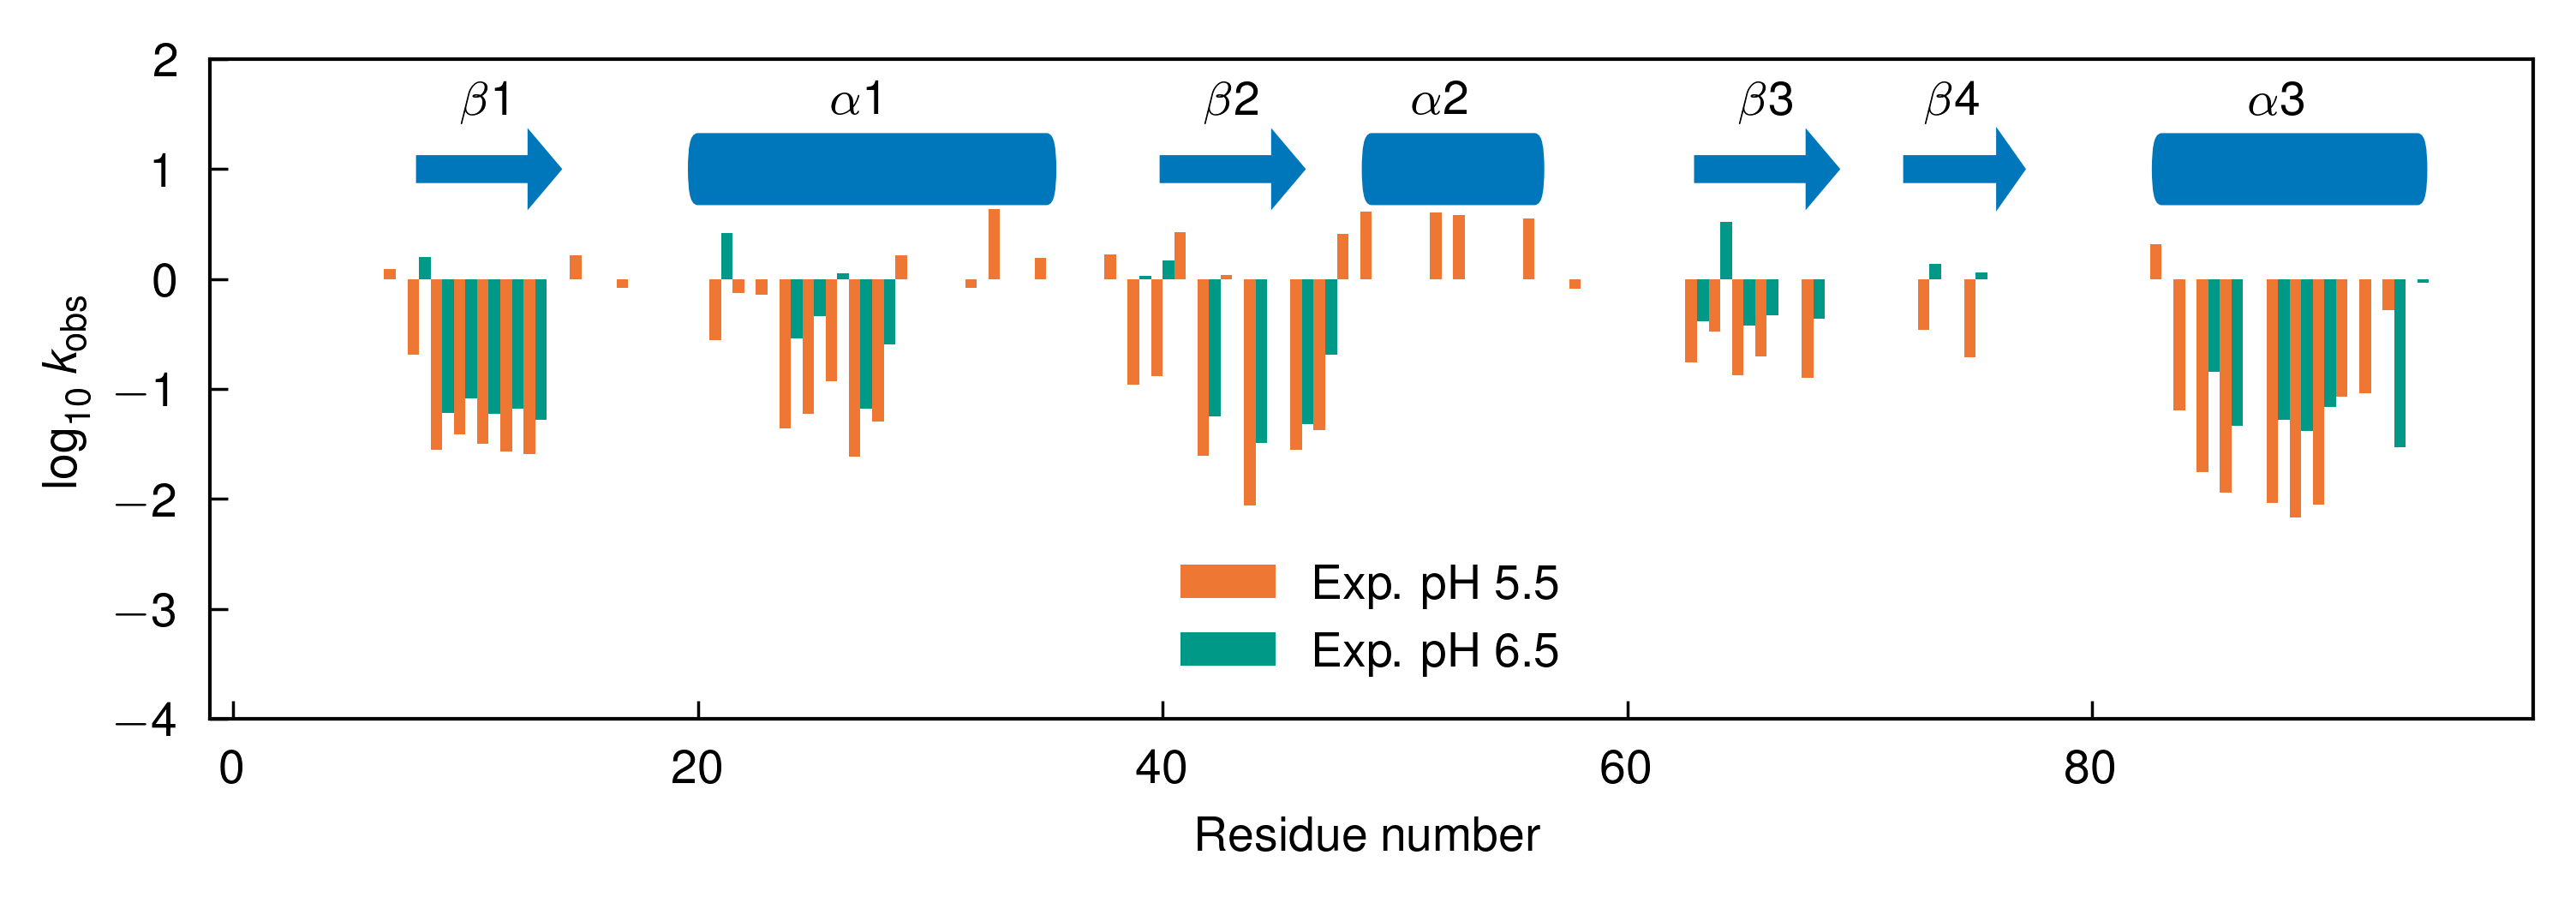

In [33]:
T_ind = 25
kobs_ph5_dg, kobs_ph6_dg = pad_and_convert(T_ind)

y = 1.0

fig = plt.figure(dpi=500, figsize=(7, 2))
ax = fig.gca()
plt.bar(
    range(len(seq)), np.log10(kobs_ph5_pad[:, 0]), align="edge", width=-0.5, label="Exp. pH 5.5", color="C0"
)
plt.bar(
    range(len(seq)), np.log10(kobs_ph6_pad[:, 0]), align="edge", width=0.5, label="Exp. pH 6.5", color="C5"
)
plt.xlim([-1, len(seq)])
plt.ylim([-4, 2])
ax.set_ylabel(r"$\log_{10}k_{\mathrm{obs}}$")
ax.set_xlabel("Residue number")
plt.legend(loc="lower center")
ax = draw_ss(ax, y)
fig.savefig("figures/log10kobs_exp.pdf", bbox_inches='tight')
plt.show()

/scratch/local/jobs/18762625/ipykernel_11128/3698657652.py:9: RuntimeWarning: divide by zero encountered in log10
  range(len(seq)), np.log10(kobs_ph5_pad[:, 0]), align="edge", width=-0.5, label="Exp. pH 5.5", color="C0"
/scratch/local/jobs/18762625/ipykernel_11128/3698657652.py:11: RuntimeWarning: divide by zero encountered in log10
  plt.bar(range(len(seq)), np.log10(kobs_ph5_dg), align="edge", width=0.5, label="Upside pH 5.5", color="C5")


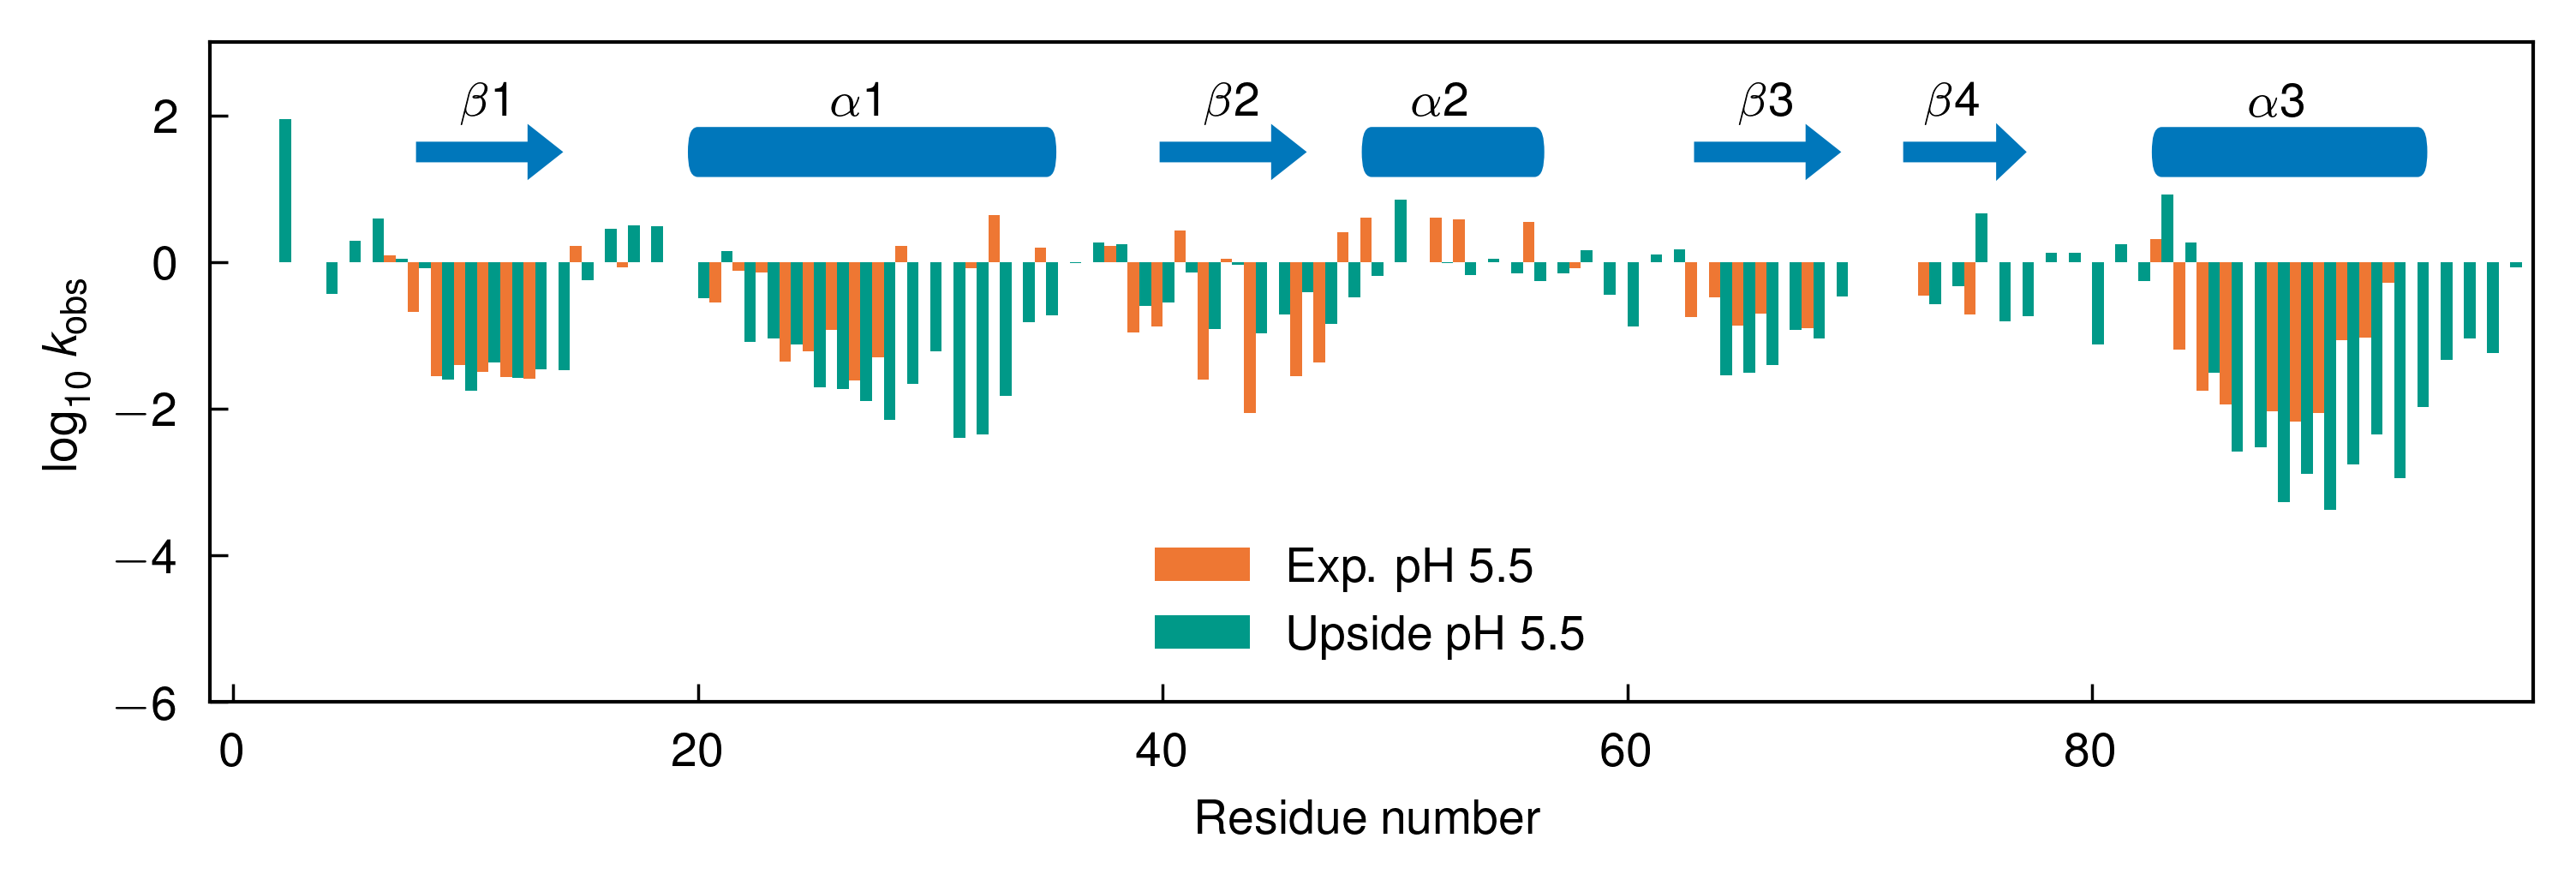

/scratch/local/jobs/18762625/ipykernel_11128/3698657652.py:26: RuntimeWarning: divide by zero encountered in log10
  range(len(seq)), np.log10(kobs_ph6_pad[:, 0]), align="edge", width=-0.5, label="Exp. pH 6.5", color="C0"
/scratch/local/jobs/18762625/ipykernel_11128/3698657652.py:28: RuntimeWarning: divide by zero encountered in log10
  plt.bar(range(len(seq)), np.log10(kobs_ph6_dg), align="edge", width=0.5, label="Upside pH 6.5", color="C5")


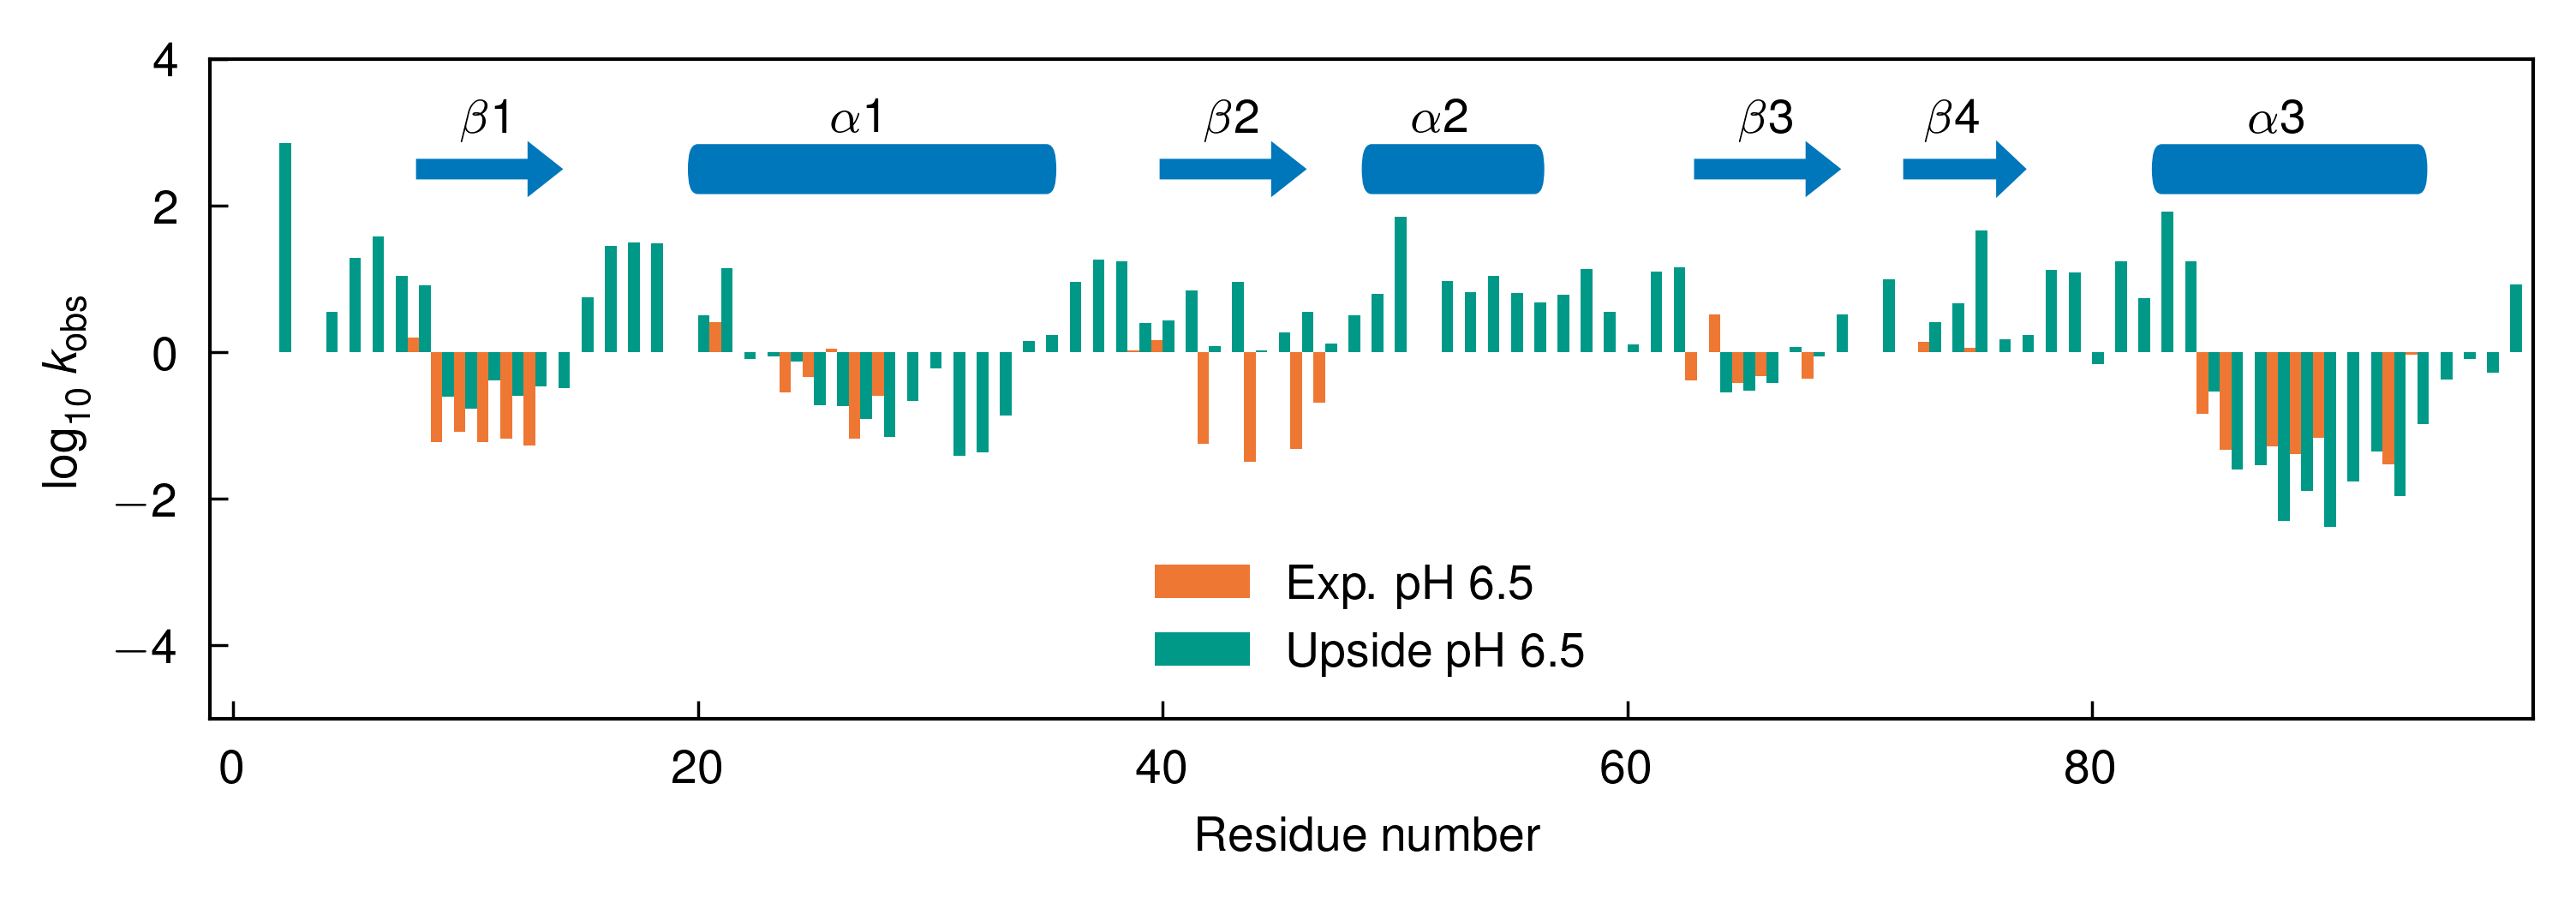

In [21]:
T_ind = 25
kobs_ph5_dg, kobs_ph6_dg = pad_and_convert(T_ind)

y = 1.5

fig = plt.figure(dpi=500, figsize=(7, 2))
ax = fig.gca()
plt.bar(
    range(len(seq)), np.log10(kobs_ph5_pad[:, 0]), align="edge", width=-0.5, label="Exp. pH 5.5", color="C0"
)
plt.bar(range(len(seq)), np.log10(kobs_ph5_dg), align="edge", width=0.5, label="Upside pH 5.5", color="C5")
plt.xlim([-1, len(seq)])
plt.ylim([-6, 3])
ax.set_ylabel(r"$\log_{10}k_{\mathrm{obs}}$")
ax.set_xlabel("Residue number")
plt.legend(loc="lower center")
ax = draw_ss(ax, y)

plt.show()

y = 2.5

fig = plt.figure(dpi=500, figsize=(7, 2))
ax = fig.gca()
plt.bar(
    range(len(seq)), np.log10(kobs_ph6_pad[:, 0]), align="edge", width=-0.5, label="Exp. pH 6.5", color="C0"
)
plt.bar(range(len(seq)), np.log10(kobs_ph6_dg), align="edge", width=0.5, label="Upside pH 6.5", color="C5")
plt.xlim([-1, len(seq)])
plt.ylim([-5, 4])
ax.set_ylabel(r"$\log_{10}k_{\mathrm{obs}}$")
ax.set_xlabel("Residue number")
plt.legend(loc="lower center")
ax = draw_ss(ax, y)

plt.show()

0.8781988620758057


/scratch/local/jobs/18762625/ipykernel_11128/1149555329.py:10: RuntimeWarning: divide by zero encountered in log10
  range(len(seq)), np.log10(kobs_ph5_pad[:, 0]), align="edge", width=-0.5, label="Exp. pH 5.5", color="C0"
/scratch/local/jobs/18762625/ipykernel_11128/1149555329.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.bar(range(len(seq)), np.log10(kobs_ph5_dg), align="edge", width=0.5, label="Upside pH 5.5", color="C5")


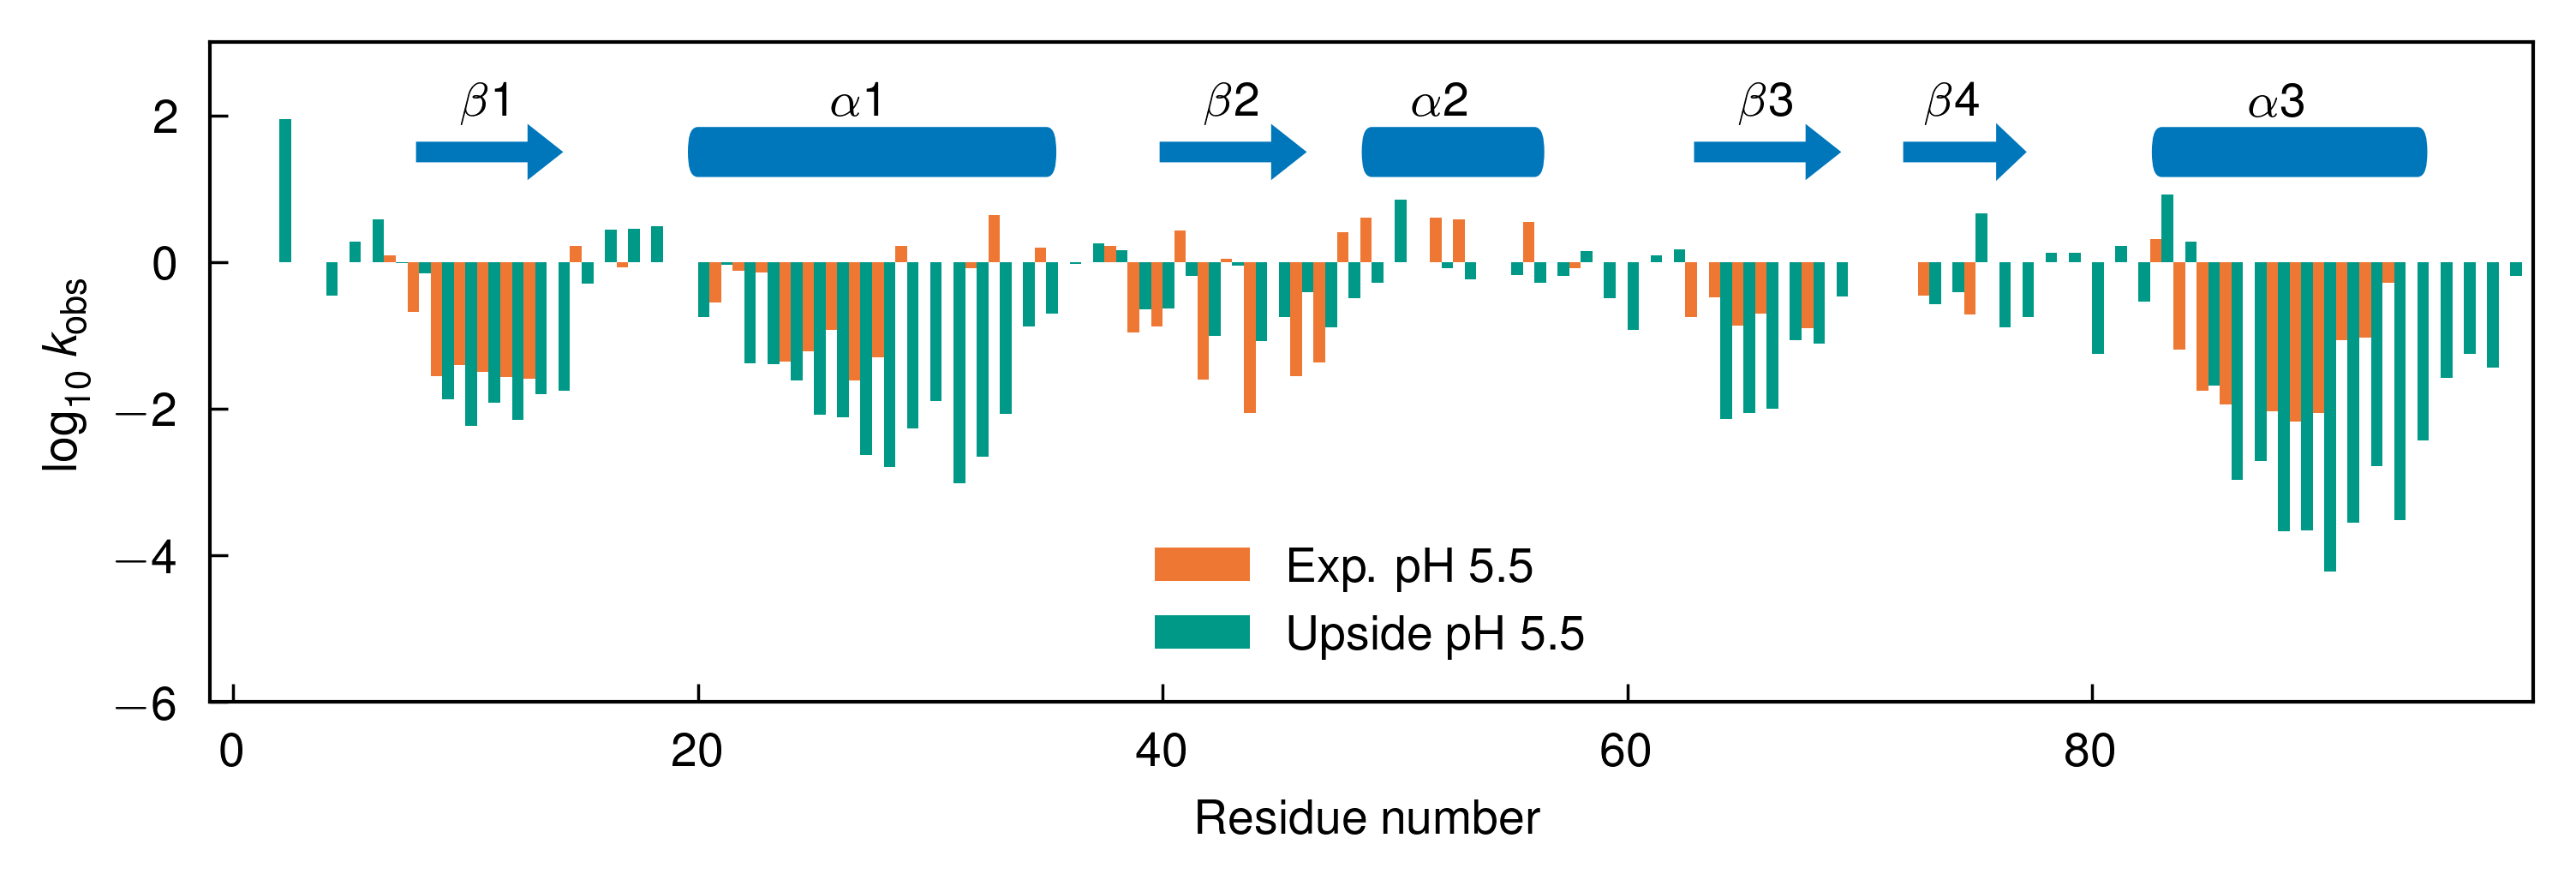

/scratch/local/jobs/18762625/ipykernel_11128/1149555329.py:27: RuntimeWarning: divide by zero encountered in log10
  range(len(seq)), np.log10(kobs_ph6_pad[:, 0]), align="edge", width=-0.5, label="Exp. pH 6.5", color="C0"
/scratch/local/jobs/18762625/ipykernel_11128/1149555329.py:29: RuntimeWarning: divide by zero encountered in log10
  plt.bar(range(len(seq)), np.log10(kobs_ph6_dg), align="edge", width=0.5, label="Upside pH 6.5", color="C5")


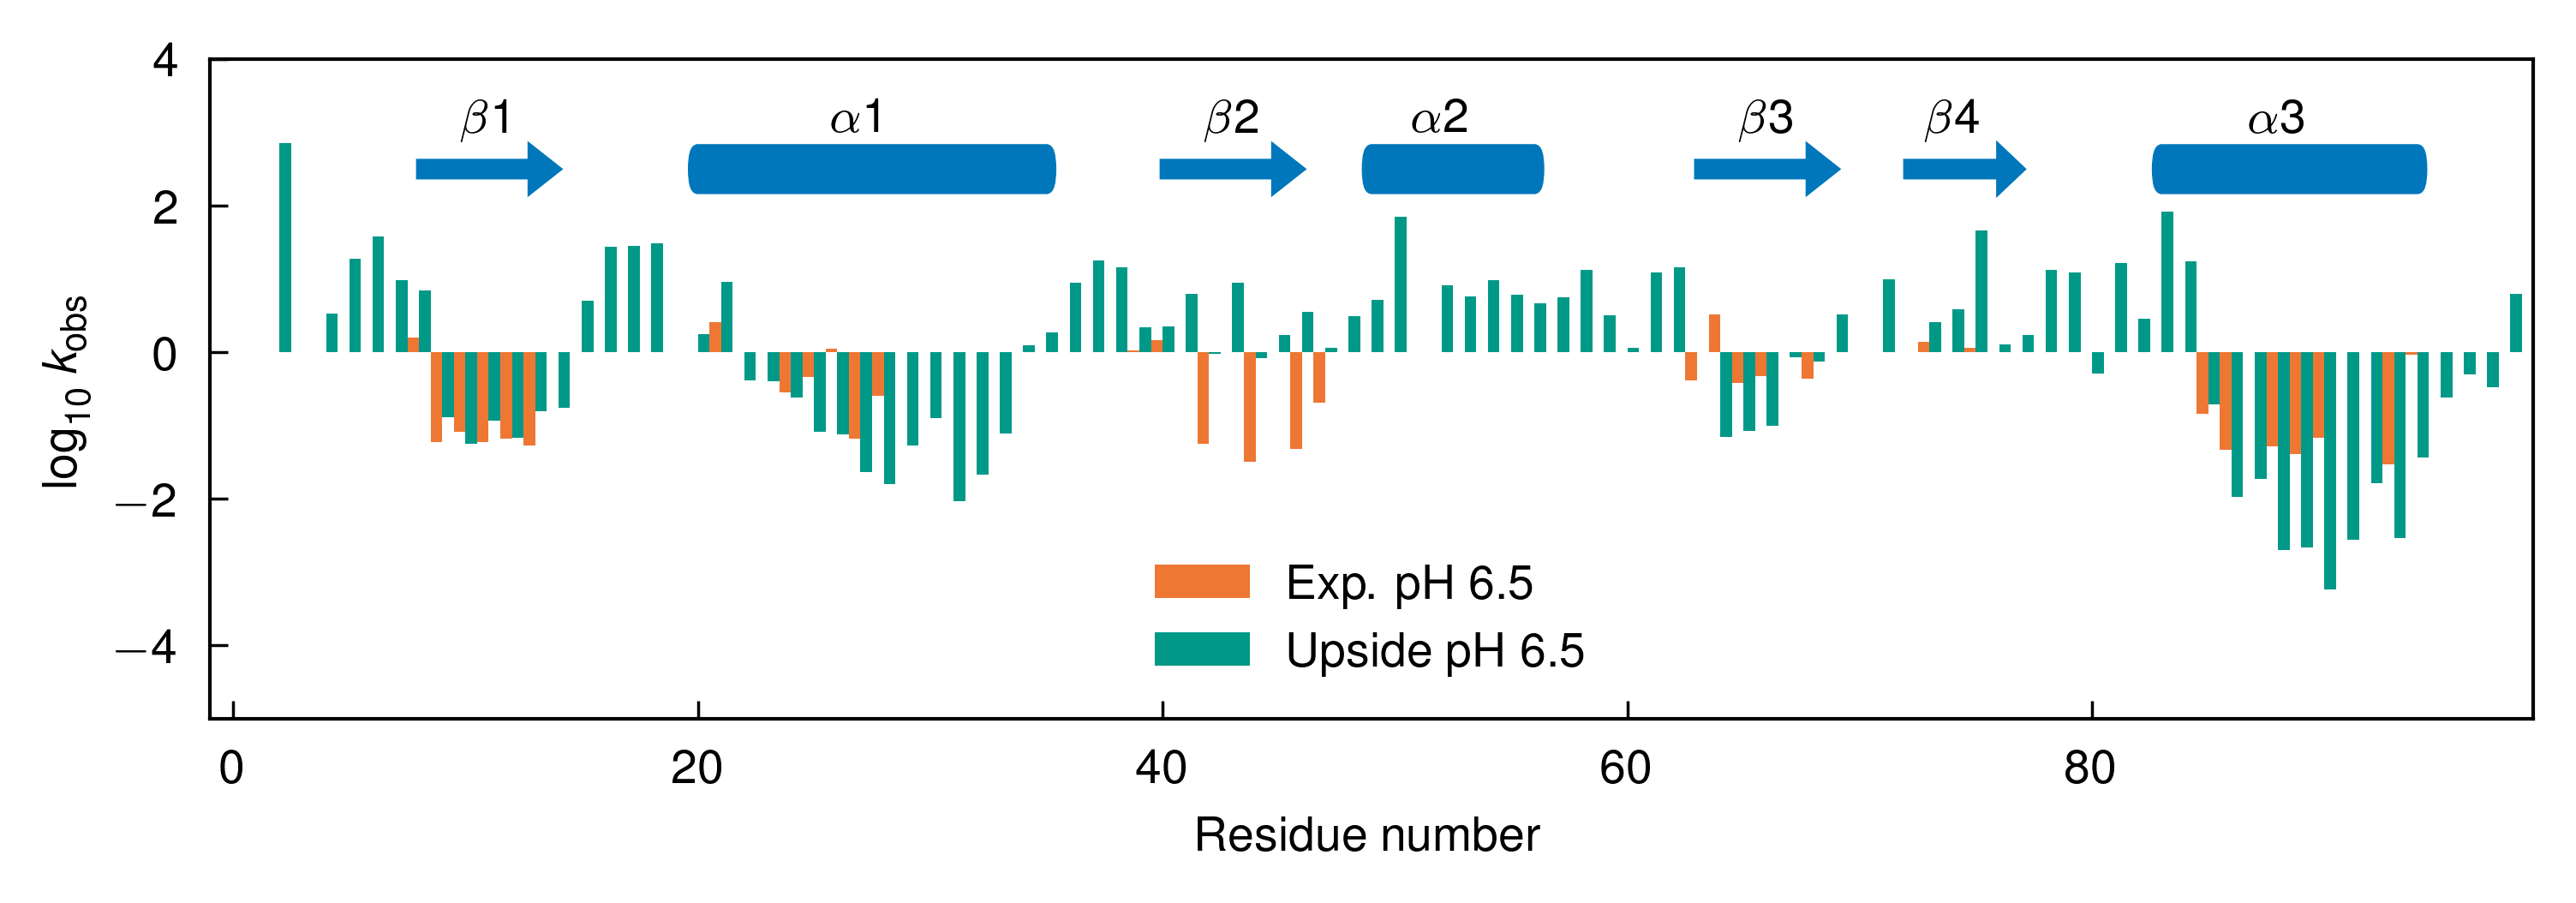

In [22]:
T_ind = 20
print(Ts[T_ind])
kobs_ph5_dg, kobs_ph6_dg = pad_and_convert(T_ind)

y = 1.5

fig = plt.figure(dpi=500, figsize=(7, 2))
ax = fig.gca()
plt.bar(
    range(len(seq)), np.log10(kobs_ph5_pad[:, 0]), align="edge", width=-0.5, label="Exp. pH 5.5", color="C0"
)
plt.bar(range(len(seq)), np.log10(kobs_ph5_dg), align="edge", width=0.5, label="Upside pH 5.5", color="C5")
plt.xlim([-1, len(seq)])
plt.ylim([-6, 3])
ax.set_ylabel(r"$\log_{10}k_{\mathrm{obs}}$")
ax.set_xlabel("Residue number")
plt.legend(loc="lower center")
ax = draw_ss(ax, y)

plt.show()

y = 2.5

fig = plt.figure(dpi=500, figsize=(7, 2))
ax = fig.gca()
plt.bar(
    range(len(seq)), np.log10(kobs_ph6_pad[:, 0]), align="edge", width=-0.5, label="Exp. pH 6.5", color="C0"
)
plt.bar(range(len(seq)), np.log10(kobs_ph6_dg), align="edge", width=0.5, label="Upside pH 6.5", color="C5")
plt.xlim([-1, len(seq)])
plt.ylim([-5, 4])
ax.set_ylabel(r"$\log_{10}k_{\mathrm{obs}}$")
ax.set_xlabel("Residue number")
plt.legend(loc="lower center")
ax = draw_ss(ax, y)

plt.show()

In [23]:
Ts[T_ind]

0.8781988620758057

/scratch/local/jobs/18762625/ipykernel_11128/180371264.py:7: RuntimeWarning: divide by zero encountered in log10
  ax0.bar(range(len(seq)), np.log10(kobs_ph6_pad[:, 0]), color="C0")
/scratch/local/jobs/18762625/ipykernel_11128/180371264.py:13: RuntimeWarning: divide by zero encountered in log10
  ax1.bar(range(len(seq)), np.log10(kobs_ph5_pad[:, 0]), color="C3")
/scratch/local/jobs/18762625/ipykernel_11128/180371264.py:19: RuntimeWarning: divide by zero encountered in log10
  ax2.bar(range(len(seq)), np.log10(kobs_ph5_dg), color="C4")


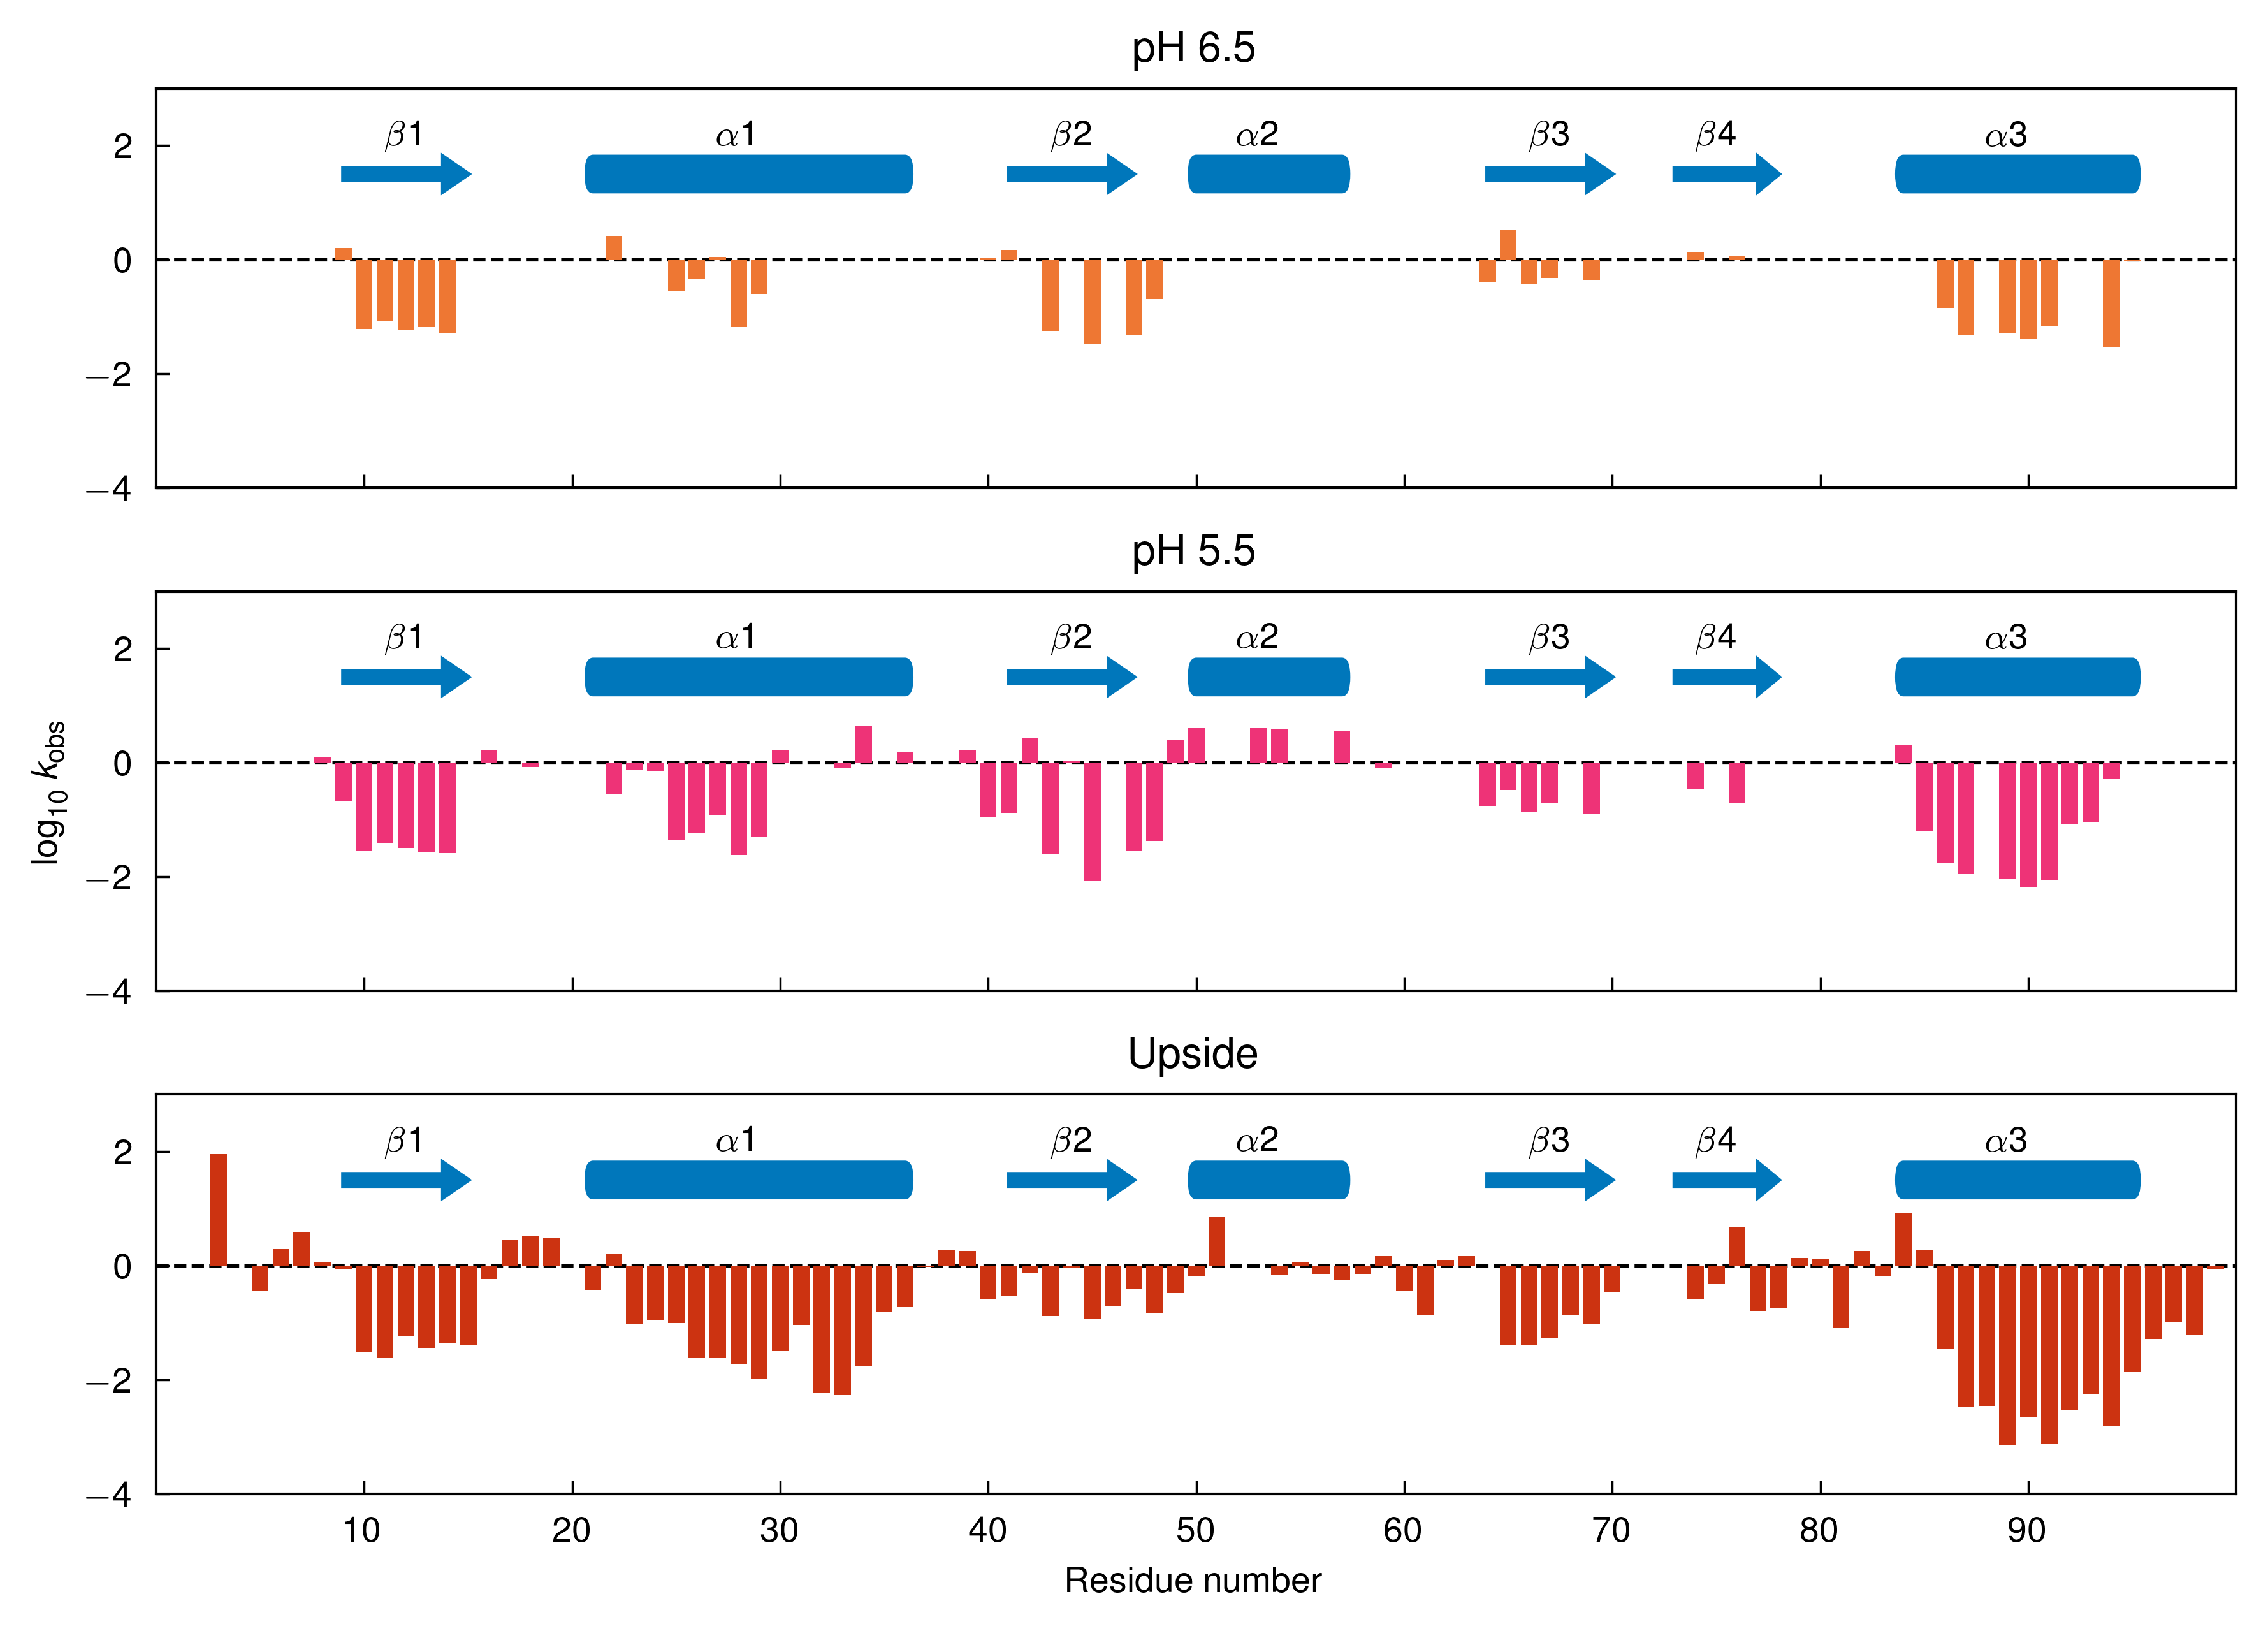

In [34]:
T_ind = 26
kobs_ph5_dg, kobs_ph6_dg = pad_and_convert(T_ind)

fig, (ax0, ax1, ax2) = plt.subplots(
    nrows=3, dpi=500, figsize=(7, 5), sharex=True, sharey=True, constrained_layout=True
)
ax0.bar(range(len(seq)), np.log10(kobs_ph6_pad[:, 0]), color="C0")
ax0.set_xlim([-1, len(seq)])
ax0.set_ylim([-4, 3])
ax0 = draw_ss(ax0, 1.5)
ax0.set_title("pH 6.5")

ax1.bar(range(len(seq)), np.log10(kobs_ph5_pad[:, 0]), color="C3")
ax1.set_xlim([-1, len(seq)])
# ax1.set_ylim([-5, 3])
ax1 = draw_ss(ax1, 1.5)
ax1.set_title("pH 5.5")

ax2.bar(range(len(seq)), np.log10(kobs_ph5_dg), color="C4")
ax2.set_xlim([-1, len(seq)])

ax2 = draw_ss(ax2, 1.5)
ax2.set_title("Upside")

ax1.set_ylabel(r"$\log_{10}k_{\mathrm{obs}}$")
ax2.set_xlabel("Residue number")
ax2.set_xticks(np.arange(9, 99, 10), labels=np.arange(10, 100, 10))
for ax in (ax0, ax1, ax2):
    ax.axhline(0, ls="--", color="k", zorder=0)
fig.savefig("figures/log10kobs_all.pdf", bbox_inches='tight')
plt.show()

In [25]:
ids5 = kobs_ph5_pad[:, 0] != 0
ids6 = kobs_ph6_pad[:, 0] != 0
ids = ids5 == ids6

kchem_ph5_pad = np.zeros(len(seq))
kchem_ph6_pad = np.zeros(len(seq))
for i in range(len(seq)):
    if i in kchem_ph5[:, 0]:
        kchem_ph5_pad[i] = kchem_ph5[np.where(kchem_ph5[:, 0] == i), 1]
    if i in kchem_ph6[:, 0]:
        kchem_ph6_pad[i] = kchem_ph6[np.where(kchem_ph6[:, 0] == i), 1]

In [26]:
(kobs_ph5_pad[:, 0] > kobs_ph6_pad[:, 0]).nonzero()

(array([ 7, 15, 17, 22, 23, 29, 32, 33, 35, 38, 41, 43, 48, 49, 52, 53, 56,
        58, 83, 84, 91, 92, 93]),)

/scratch/local/jobs/18762625/ipykernel_11128/2351894187.py:10: RuntimeWarning: divide by zero encountered in log10
  plt.plot([5.5, 6.5], [np.log10(kobs_ph5_pad[i, 0]), np.log10(kobs_ph6_pad[i, 0])], '.-', color=color_arr[i])


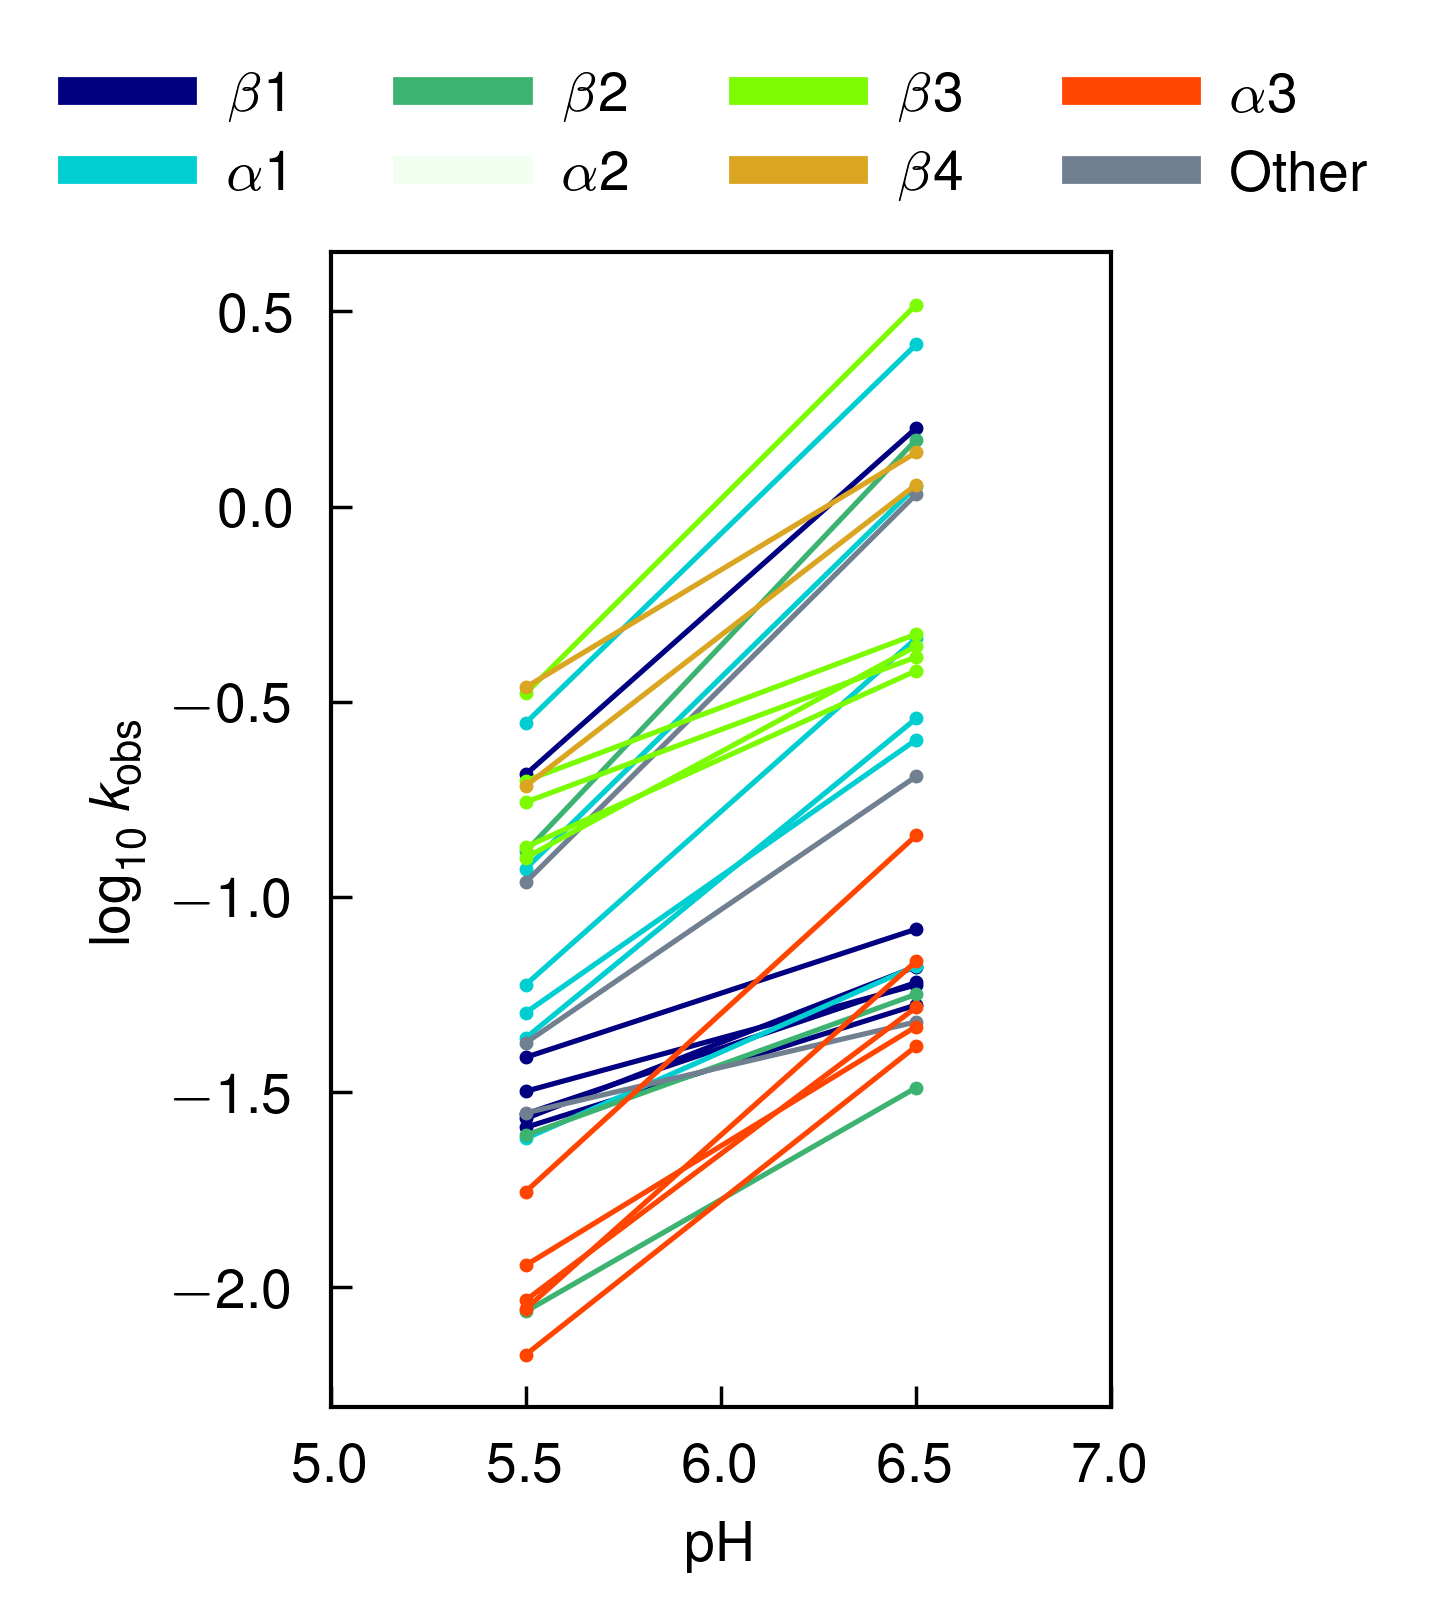

In [27]:
y = 2.5

fig = plt.figure(dpi=500, figsize=(4, 3))
ax = fig.gca()
# plt.plot(np.ones(76) * 5.5, np.log10(kobs_ph5_pad[ids, 0]), "o", label="Exp. pH 5.5", color="k")
# plt.plot(np.ones(76) * 6.5, np.log10(kobs_ph6_pad[ids, 0]), "o", label="Exp. pH 6.5", color="k")
for i in ids.nonzero()[0]:
    if i == 93:
        continue
    plt.plot([5.5, 6.5], [np.log10(kobs_ph5_pad[i, 0]), np.log10(kobs_ph6_pad[i, 0])], '.-', color=color_arr[i])
plt.xlim([5, 7])
# plt.ylim([-5, 4])
ax.set_ylabel(r"$\log_{10}k_{\mathrm{obs}}$")
ax.set_xlabel("pH")
# plt.legend(loc='lower center')
# ax = draw_ss(ax, y)
ax.legend(custom_lines, ss_labels, loc='center', bbox_to_anchor=(0.5, 1.1), ncol=4)
ax.set_aspect("equal")
plt.show()

/scratch/local/jobs/18762625/ipykernel_11128/3542097719.py:8: RuntimeWarning: divide by zero encountered in log10
  ax0.plot([5.5, 6.5], [np.log10(kobs_ph5_pad[i, 0]), np.log10(kobs_ph6_pad[i, 0])], '.-', color=color_arr[i])
/scratch/local/jobs/18762625/ipykernel_11128/3542097719.py:11: RuntimeWarning: invalid value encountered in scalar divide
  [np.log10(kobs_ph5_pad[i, 0] / kchem_ph5_pad[i]), np.log10(kobs_ph6_pad[i, 0] / kchem_ph6_pad[i])],
/scratch/local/jobs/18762625/ipykernel_11128/3542097719.py:11: RuntimeWarning: divide by zero encountered in log10
  [np.log10(kobs_ph5_pad[i, 0] / kchem_ph5_pad[i]), np.log10(kobs_ph6_pad[i, 0] / kchem_ph6_pad[i])],
/scratch/local/jobs/18762625/ipykernel_11128/3542097719.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  [np.log10(kobs_ph5_pad[i, 0] / kchem_ph5_pad[i]), np.log10(kobs_ph6_pad[i, 0] / kchem_ph6_pad[i])],


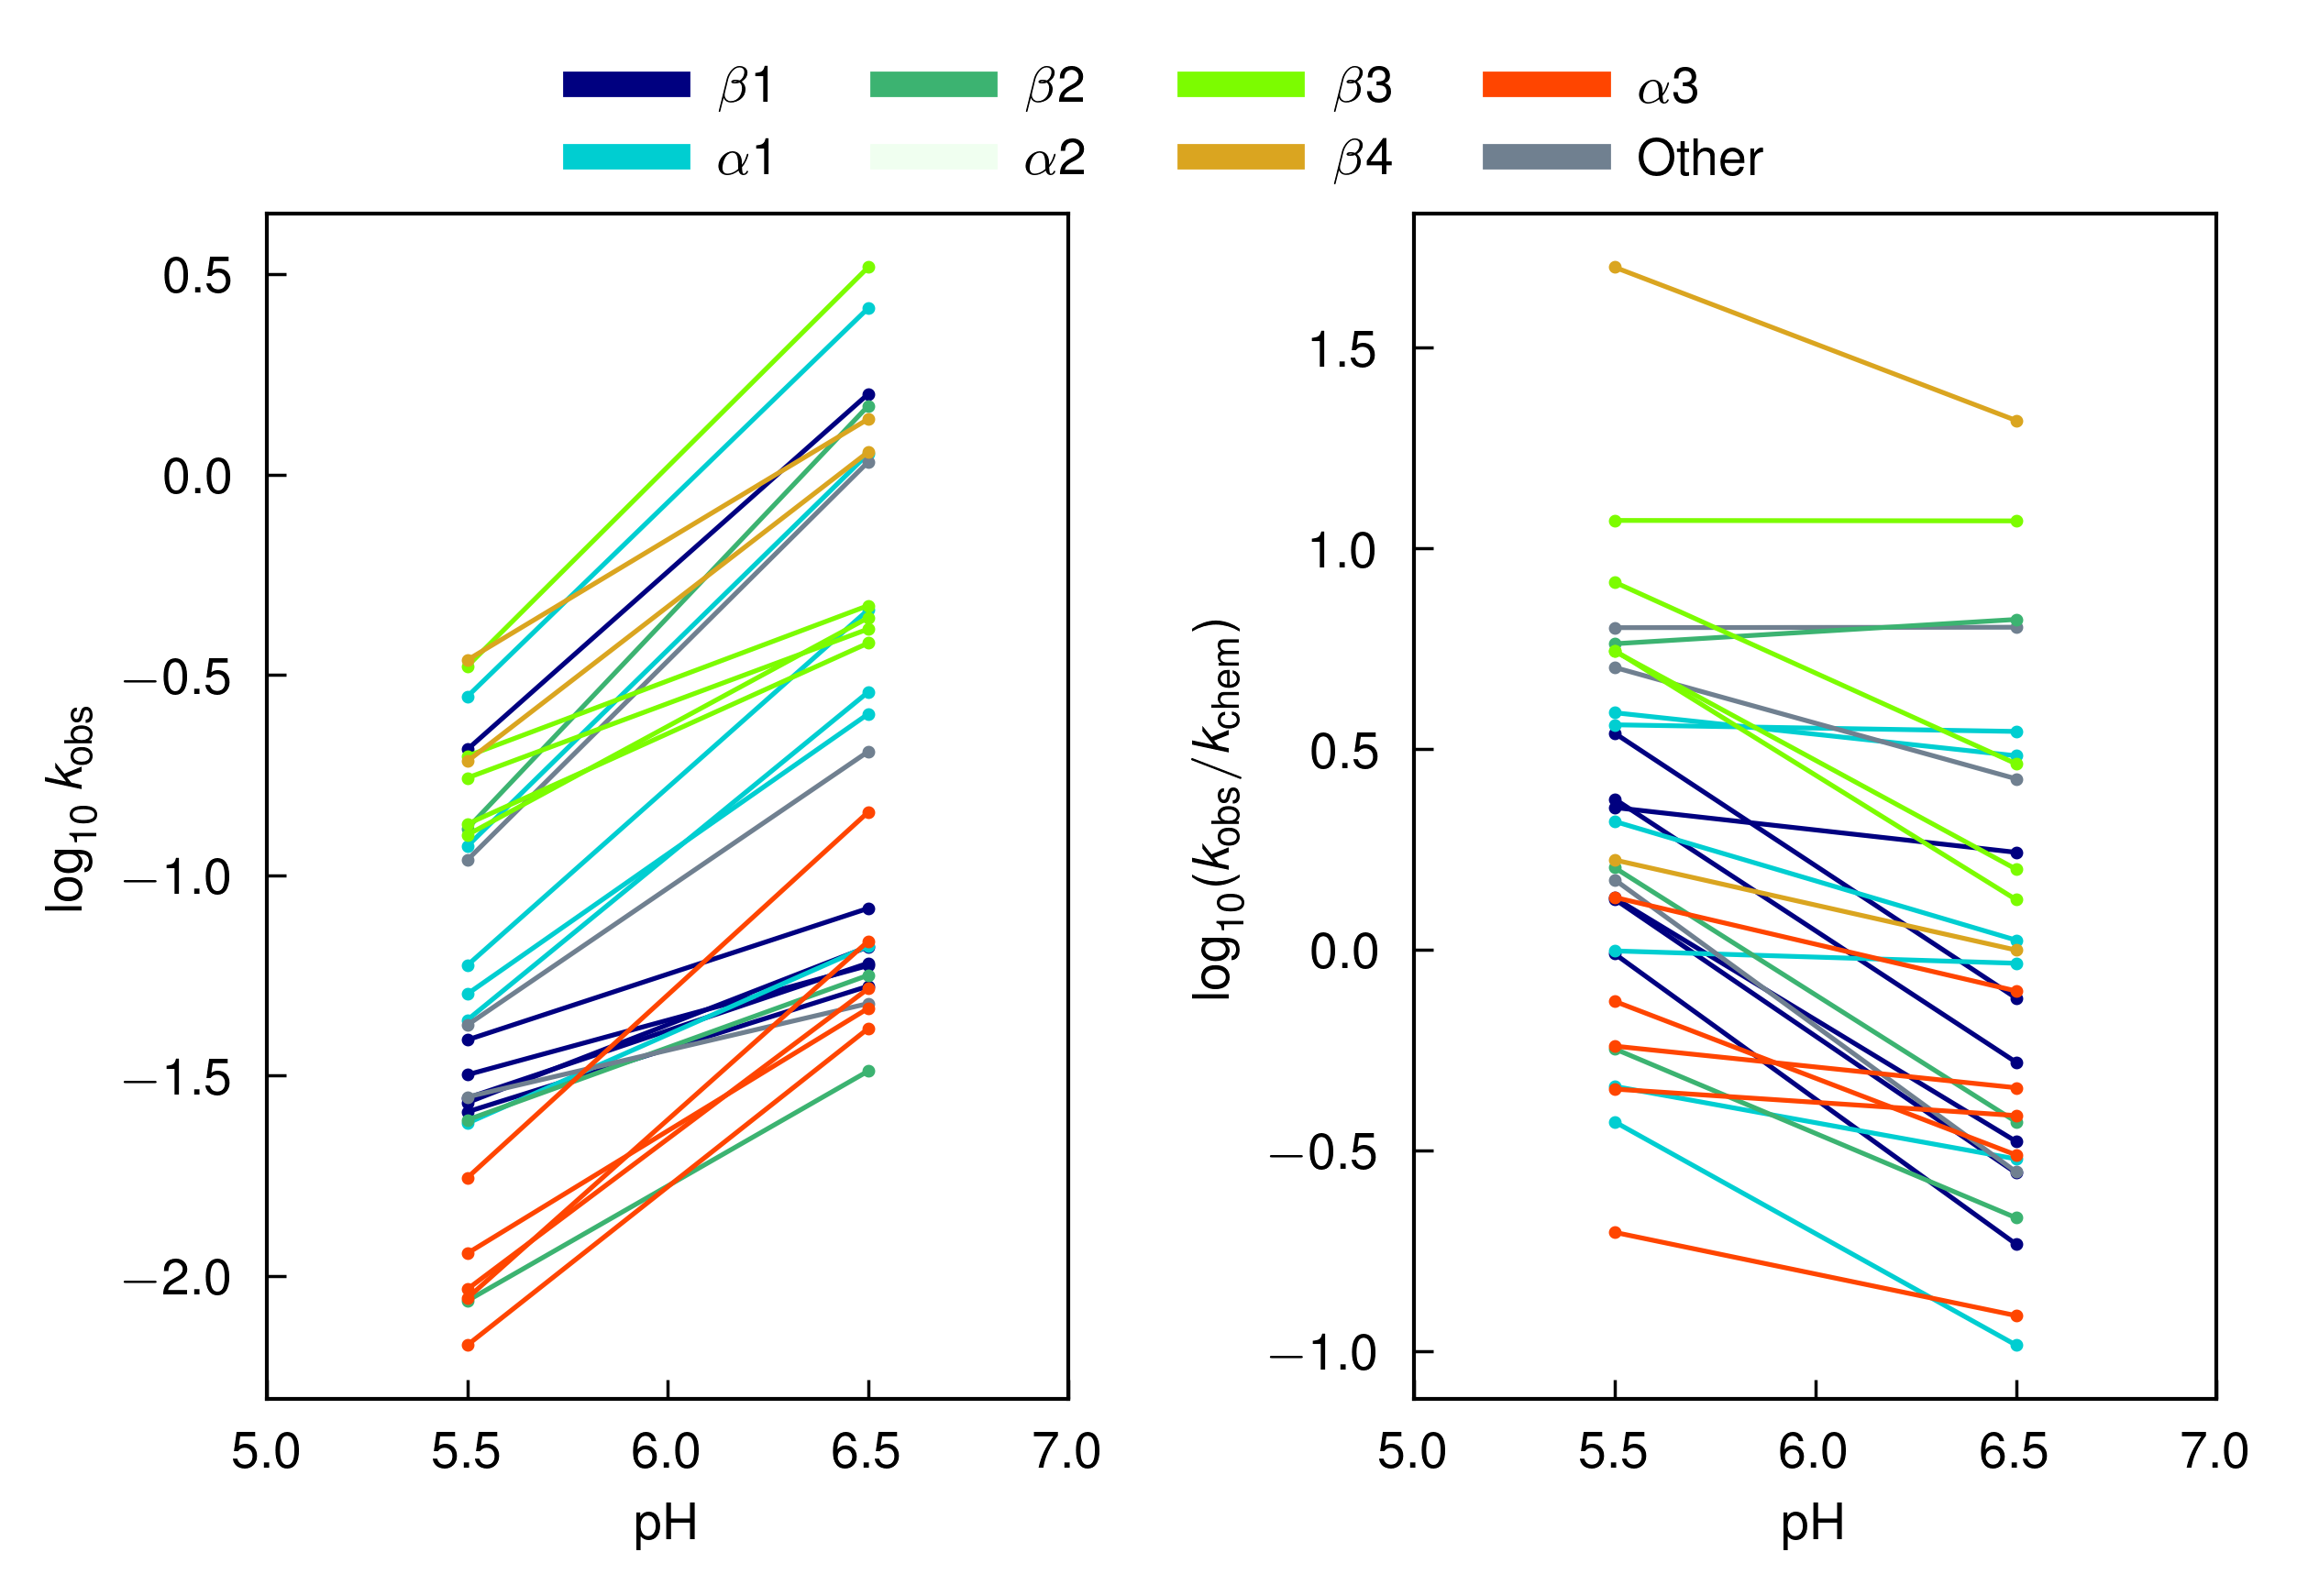

In [35]:
fig, (ax0, ax1) = plt.subplots(ncols=2, dpi=500, figsize=(5, 3), sharex=True, constrained_layout=True)
ax = fig.gca()
# plt.plot(np.ones(76) * 5.5, np.log10(kobs_ph5_pad[ids, 0]), "o", label="Exp. pH 5.5", color="k")
# plt.plot(np.ones(76) * 6.5, np.log10(kobs_ph6_pad[ids, 0]), "o", label="Exp. pH 6.5", color="k")
for i in ids.nonzero()[0]:
    if i == 93:
        continue
    ax0.plot([5.5, 6.5], [np.log10(kobs_ph5_pad[i, 0]), np.log10(kobs_ph6_pad[i, 0])], '.-', color=color_arr[i])
    ax1.plot(
        [5.5, 6.5],
        [np.log10(kobs_ph5_pad[i, 0] / kchem_ph5_pad[i]), np.log10(kobs_ph6_pad[i, 0] / kchem_ph6_pad[i])],
        ".-",
        color=color_arr[i],
    )

for ax in (ax0, ax1):
    ax.set_xlim([5, 7])
    ax.set_xlabel("pH")
    ax.set_aspect("equal")
ax0.set_ylabel(r"$\log_{10}k_{\mathrm{obs}}$")
ax1.set_ylabel(r"$\log_{10}(k_{\mathrm{obs}} / k_{\mathrm{chem}})$")

fig.legend(custom_lines, ss_labels, loc='center', bbox_to_anchor=(0.5, 1.05), ncol=4)
fig.savefig("figures/kobs_kchem_pH_ss.pdf", bbox_inches='tight')
plt.show()